## 0. Libraries and Personal Tools

In [1]:
import sys
from os.path import abspath

from multiprocessing import cpu_count
from gc import collect

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the default figure size and theme to display good looking matplotlib plots.
rcParams["figure.figsize"] = (10, 6)
plt.style.use("fivethirtyeight")

In [3]:
from pandas import set_option
set_option("display.max_rows", 200)
set_option("display.max_columns", 100)
set_option("display.max_colwidth", 200)

In [4]:
# add absolute path from root to sys.path to use custom modules
sys.path.insert(0, abspath('..'))

from src.models.train_model import BaseModel

## 1. Build Base Model

In [5]:
base_model = BaseModel()
base_model.read_config("../models/config.yaml")
features, target = base_model.get_data()
base_model.build_base_pipeline()

In [6]:
base_model.base_pipeline

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('player',
                                                 ColumnTransformer(transformers=[('demolished',
                                                                                  PlayerDemolished(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7cd54b430>),
                                                                                 ('position',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0.0,
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.c...
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   MaxAbsScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7cc4abdc0>)])),
                                                ('team',
                                                 ColumnTransformer(transformers=[('centroid',
                                                                                  Pipeline(steps=[('team_centroid',
                                                                                                   TeamCentroid()),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7cc4abaf0>)]))]))])

In [7]:
# from pandas.core.frame import DataFrame
# DataFrame(base_model.base_pipeline.fit_transform(base_model.data)).isna().sum().sum()
# DataFrame(base_model.base_pipeline.fit_transform(base_model.data)).shape

## 2. Parameter Optimization

### 2.1. Split Data

In [8]:
from src.utils import create_kf_groups

from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, GroupKFold

from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper, CheckpointSaver
from skopt.space import Real, Categorical, Integer

In [9]:
from sklearn.model_selection import GroupShuffleSplit

gsp = GroupShuffleSplit(n_splits=2, test_size=0.20, random_state=777)
train_index, test_index = next(gsp.split(base_model.data, groups=base_model.data.index.get_level_values("game_num")))

X_train = base_model.data[features + [target]].iloc[train_index]

X_valid = base_model.data[features].iloc[test_index]
y_valid = base_model.data[target].iloc[test_index]

In [10]:
train_index, test_index = next(gsp.split(X_train, groups=X_train.index.get_level_values("game_num")))

X_train_cv = X_train[features].iloc[train_index]
y_train_cv = X_train[target].iloc[train_index]

X_test = X_train[features].iloc[test_index]
y_test = X_train[target].iloc[test_index]

In [11]:
print(f"X_train_cv.shape: {X_train_cv.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"X_valid.shape: {X_valid.shape}")

X_train_cv.shape: (1358639, 54)
X_test.shape: (338135, 54)
X_valid.shape: (422949, 54)


In [12]:
del X_train

In [13]:
base_model.base_pipeline.fit(base_model.data)
X_test_transformed = base_model.base_pipeline.transform(X_test)

In [14]:
base_model.base_pipeline

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('player',
                                                 ColumnTransformer(transformers=[('demolished',
                                                                                  PlayerDemolished(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7cd54b430>),
                                                                                 ('position',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0.0,
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.c...
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   MaxAbsScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7cc4abdc0>)])),
                                                ('team',
                                                 ColumnTransformer(transformers=[('centroid',
                                                                                  Pipeline(steps=[('team_centroid',
                                                                                                   TeamCentroid()),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7cc4abaf0>)]))]))])

In [15]:
# from pandas.core.frame import DataFrame
# DataFrame(base_model.base_pipeline.fit_transform(X_train_cv)).describe().transpose()

In [16]:
n_folds = 5

game_num = X_train_cv.index.get_level_values("game_num")
groups = create_kf_groups(game_num, n_folds=n_folds)

gkf = GroupKFold(n_splits=n_folds)

In [17]:
groups.value_counts()

a    275668
b    273026
c    269483
d    267850
e    272612
dtype: int64

In [18]:
if base_model.config["model"]["ipca"]["batch_size"] == "auto":
    TOTAL_IPCA_BATCHES = 50
    ipca_batch = int(round(groups.value_counts().mean() / TOTAL_IPCA_BATCHES, -3))
else:
    ipca_batch = base_model.config["model"]["ipca"]["batch_size"]
ipca_batch

5000

In [19]:
from lightgbm import LGBMClassifier
model_type = base_model.config["model"]["type"]
clf = LGBMClassifier(objective="binary", n_estimators=10000, min_child_samples=None, random_state=777)

base_model.base_pipeline.steps.append(("ipca", IncrementalPCA(batch_size=ipca_batch)))
base_model.base_pipeline.steps.append((model_type, clf))


In [20]:
space = [
    {
        "ipca__n_components": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    },
]

In [21]:
base_model.base_pipeline

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('player',
                                                 ColumnTransformer(transformers=[('demolished',
                                                                                  PlayerDemolished(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7cd54b430>),
                                                                                 ('position',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0.0,
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.c...
                                                 ColumnTransformer(transformers=[('centroid',
                                                                                  Pipeline(steps=[('team_centroid',
                                                                                                   TeamCentroid()),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7cc4abaf0>)]))])),
                ('ipca', IncrementalPCA(batch_size=5000)),
                ('lgbm',
                 LGBMClassifier(min_child_samples=None, n_estimators=10000,
                                objective='binary', random_state=777))])

In [22]:
ipca_grid_search = GridSearchCV(
    estimator=base_model.base_pipeline, 
    param_grid=space, 
    n_jobs=cpu_count(), 
    verbose=2, 
    scoring="neg_log_loss",
    cv=GroupKFold(n_splits=n_folds).split(X_train_cv, y_train_cv, groups=groups),
    )

In [23]:
ipca_grid_search.fit(
    X_train_cv, y_train_cv, 
    **{
        f"{model_type}__eval_set": [(X_test_transformed, y_test)], 
        f"{model_type}__eval_metric": "neg_log_loss", 
        f"{model_type}__callbacks": [
            early_stopping(100),
            log_evaluation(period=50, show_stdv=True), 
            ]
        }
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.222602
[50]	valid_0's binary_logloss: 0.220958
[50]	valid_0's binary_logloss: 0.221781
[50]	valid_0's binary_logloss: 0.220446
[100]	valid_0's binary_logloss: 0.220914
[100]	valid_0's binary_logloss: 0.221884
[100]	valid_0's binary_logloss: 0.222825
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.221249
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.221249
[100]	valid_0's binary_logloss: 0.220367
[CV] END ..............................ipca__n_components=10; total time= 1.6min
[CV] END ..............................ipca__n_components=10; total time= 1.6min
Early stopping, best iteration is:
[28]	valid_0's binary_

/home/ian/miniconda3/envs/kaggle-main/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[100]	valid_0's binary_logloss: 0.277047
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.22125
[CV] END ..............................ipca__n_components=70; total time= 3.6min
[50]	valid_0's binary_logloss: 0.229153
[50]	valid_0's binary_logloss: 0.239781
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.263203
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.221252
Training until validation scores don't improve for 100 rounds
[CV] END ..............................ipca__n_components=70; total time= 3.8min
[100]	valid_0's binary_logloss: 0.254994
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.221253
[CV] END ..............................ipca__n_components=70; total time= 3.7min
[50]	valid_0's binary_logloss: 0.227205
[50]	valid_0's binary_logloss: 0.252442
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7ff77673c200>,
             estimator=Pipeline(steps=[('preprocessor',
                                        FeatureUnion(transformer_list=[('player',
                                                                        ColumnTransformer(transformers=[('demolished',
                                                                                                         PlayerDemolished(),
                                                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7cd54b430>),
                                                                                                        ('position',
                                                                                                         Pipeline(steps=[('imputer',
                                                                                                                          SimpleImputer(f...
                                                                                                                          StandardScaler())]),
                                                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7cc4abaf0>)]))])),
                                       ('ipca',
                                        IncrementalPCA(batch_size=5000)),
                                       ('lgbm',
                                        LGBMClassifier(min_child_samples=None,
                                                       n_estimators=10000,
                                                       objective='binary',
                                                       random_state=777))]),
             n_jobs=4,
             param_grid=[{'ipca__n_components': [10, 20, 30, 40, 50, 60, 70, 80,
                                                 90, 100]}],
             scoring='neg_log_loss', verbose=2)

In [24]:
ipca_grid_search.best_params_

{'ipca__n_components': 20}

In [25]:
ipca_grid_search.best_score_

-0.21237060077047945

In [26]:
var = ipca_grid_search.best_estimator_["ipca"].explained_variance_ratio_
var_explained = var.cumsum()

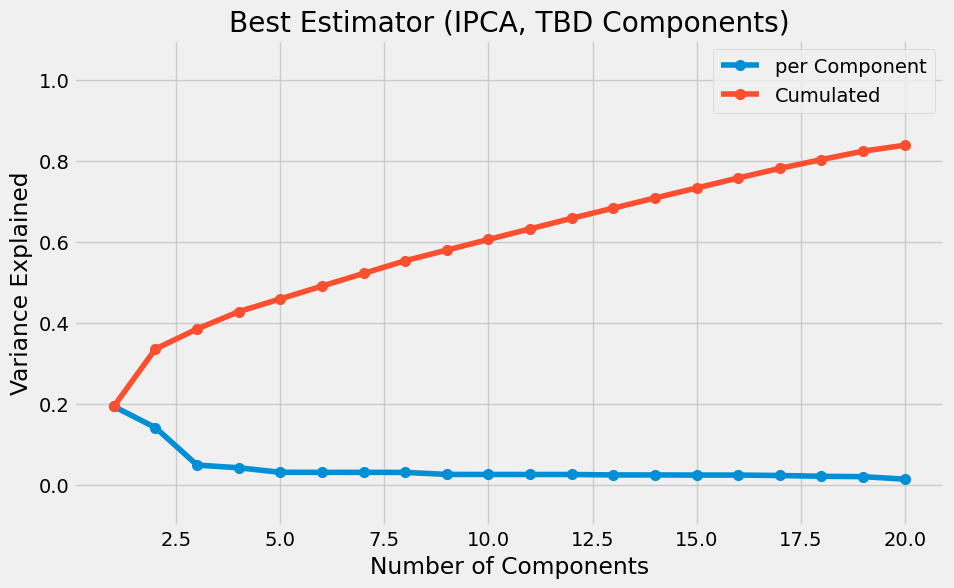

In [27]:
plt.figure()

plt.plot(range(1, len(var_explained)+1), var, label="per Component", marker="o", markersize=7)
plt.plot(range(1, len(var_explained)+1), var_explained, label="Cumulated", marker="o", markersize=7)

plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.ylim(-0.1, 1.1)

plt.title("Best Estimator (IPCA, TBD Components)")
plt.legend()
plt.show()

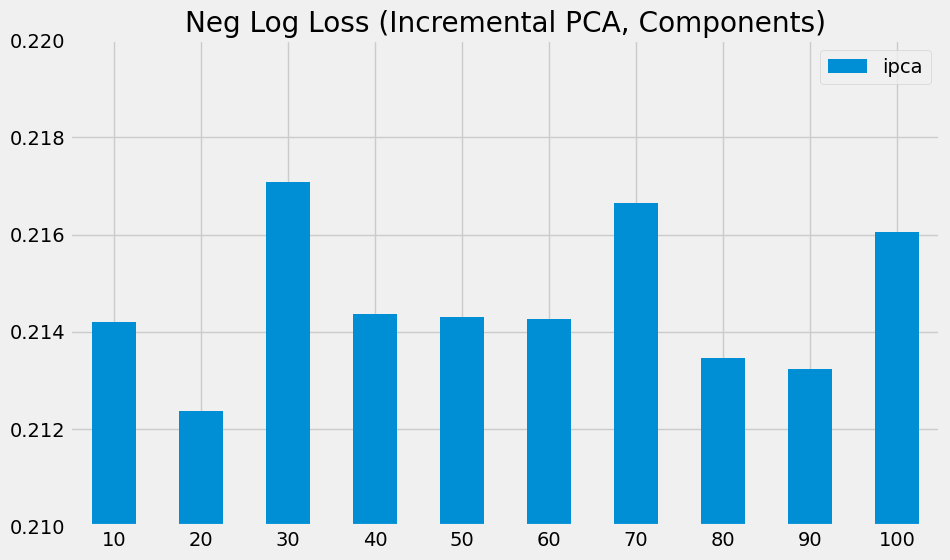

In [31]:
from pandas.core.frame import DataFrame
(
    DataFrame(
        data=ipca_grid_search.cv_results_["mean_test_score"].reshape(10, 1),
        index=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        columns=["ipca"],
        )
    .abs()
    .plot.bar(rot=0, ylim = (0.21, 0.22), title="Neg Log Loss (Incremental PCA, Components)")
);

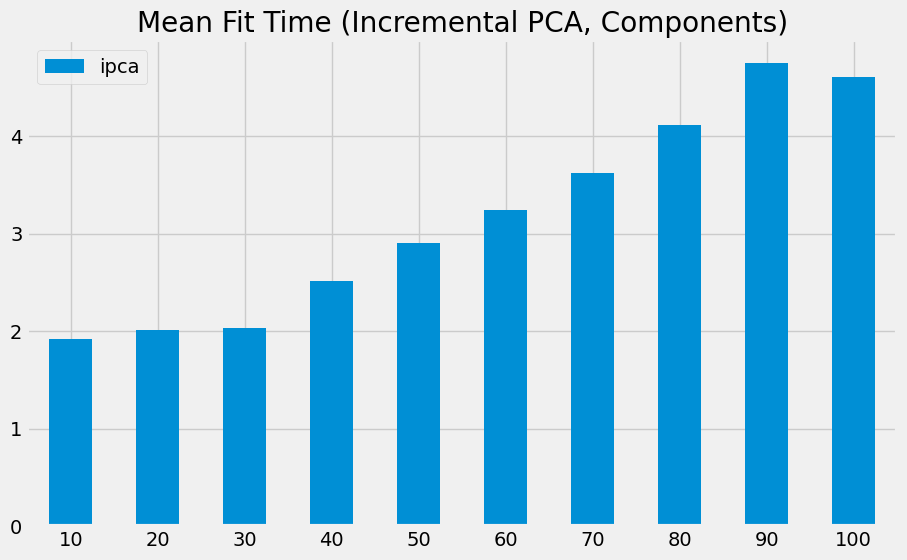

In [34]:
from pandas.core.frame import DataFrame
(
    DataFrame(
        data=ipca_grid_search.cv_results_["mean_fit_time"].reshape(10, 1),
        index=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        columns=["ipca"],
        )
    .div(60)
    .plot.bar(rot=0, title="Mean Fit Time (Incremental PCA, Components)")
);

In [43]:
if base_model.config["model"]["ipca"]["batch_size"] == "auto":
    TOTAL_IPCA_BATCHES = 50
    ipca_batch = int(round(len(X_train_cv) / TOTAL_IPCA_BATCHES, -3))
else:
    ipca_batch = base_model.config["model"]["ipca"]["batch_size"]
ipca_batch

27000

In [44]:
base_model = BaseModel()
base_model.read_config("../models/config.yaml")
features, target = base_model.get_data()
base_model.build_base_pipeline()

In [45]:
base_model.base_pipeline.steps.append((
    "ipca", 
    IncrementalPCA(
        n_components=base_model.config["model"]["ipca"]["n_components"], 
        batch_size=ipca_batch,
        whiten=base_model.config["model"]["ipca"]["whiten"]
        ),
    ))

X_test_trans = base_model.base_pipeline.fit_transform(X_test)

In [46]:
from lightgbm import LGBMClassifier
model_type = base_model.config["model"]["type"]
clf = LGBMClassifier(objective="binary", n_estimators=10000, min_child_samples=None, random_state=777)

base_model.base_pipeline.steps.append((model_type, clf))


In [47]:
fit_params = {
    f"{model_type}__eval_set": [(X_test_trans, y_test)],
    f"{model_type}__eval_metric": "neg_log_loss",
    f"{model_type}__callbacks": [
        early_stopping(250),
        log_evaluation(period=50, show_stdv=True), 
    ],
}

fit_params.keys()

dict_keys(['lgbm__eval_set', 'lgbm__eval_metric', 'lgbm__callbacks'])

In [48]:
best_ipca_model = base_model.base_pipeline.fit(X=X_train_cv, y=y_train_cv, **fit_params)

Training until validation scores don't improve for 250 rounds
[50]	valid_0's binary_logloss: 0.217353
[100]	valid_0's binary_logloss: 0.217938
[150]	valid_0's binary_logloss: 0.218189
[200]	valid_0's binary_logloss: 0.218297
[250]	valid_0's binary_logloss: 0.218515
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.215757


In [49]:
preds = best_ipca_model.predict_proba(X_valid)[:,1]

In [50]:
from sklearn.metrics import log_loss
log_loss(y_valid, preds)

0.2031486650458311